In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io as io
import scipy.signal as sig
import math as math
import random
import dynamical.nonlinear as nl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams['image.cmap'] = 'RdBu'

In [477]:
def load_res_chan(res_path, chan,load_nnR2=False):
    """
    returns MI, tau, pffn & attr_dim for one channel
    1-indexed (channel 1 is actually channel1 in ecog)
    if load_Rsq is True, load also del_R and attr_size
    """
    
    res_chan = sp.io.loadmat(result_path +'forecast_chan' + str(chan) + '.mat', struct_as_record=False, squeeze_me=True)['results']
    MI = np.array([seg.MI for seg in res_chan])
    tau = np.array([seg.tau for seg in res_chan])
    pffn = np.array([seg.pffn for seg in res_chan])
    attr_dim = np.array([seg.attr_dim for seg in res_chan])
    if load_nnR2:
        del_R = np.array([seg.del_R for seg in res_chan])
        attr_size = np.array([seg.attr_size for seg in res_chan])
        return MI, tau, pffn, attr_dim, del_R, attr_size
    else:
        return MI, tau, pffn, attr_dim
    
def ctx_viz(ctx_file, data='none', chans='none', ms=20.):
    """
    plots the cortex image, optionally scale colors by 
    a 1-D data vector
    """
    ctx_mat = sp.io.loadmat(ctx_file, squeeze_me=True)
    if data is not 'none' and chans is 'none':
        #need to fill in channel numbers
        chans = np.arange(len(data))
        
    plt.imshow(ctx_mat['I'])
    if data is 'none':
#        plt.plot(ctx_mat['X'],ctx_mat['Y'], 'ko', ms=ms)
        plt.scatter(ctx_mat['X'],ctx_mat['Y'], marker='o', c='w', s=ms) 
    else:
        plt.scatter(ctx_mat['X'][chans],ctx_mat['Y'][chans], marker='o', s=ms, c=data, cmap='Blues') 
        cbar = plt.colorbar(fraction=0.05)
        cbar.set_ticks([min(data),max(data)])
    
    plt.box('off')    
    plt.xlim([50, 950])
    plt.ylim([1200, 40])
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()

In [13]:
exp = 'forecasting_diff/'
result_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/'+exp

chan = 1
res_chan = sp.io.loadmat(result_path +'forecast_chan' + str(chan) + '.mat', struct_as_record=False, squeeze_me=True)
n_segs=res_chan['rmse'].shape[0]
#60, 8, 25, 20
dim=3
future=20
nn=10
channels = np.append(np.arange(1,63), np.arange(64,129))
rmse = np.zeros((len(channels),n_segs))
rho = np.zeros((len(channels),n_segs))
for idx, chan in enumerate(channels):
    print chan,
    res_chan = sp.io.loadmat(result_path +'forecast_chan' + str(chan) + '.mat', struct_as_record=False, squeeze_me=True)
#     rho[idx,:] = res_chan['rho'][:,dim,future,nn]
#     rmse[idx,:] = res_chan['rmse'][:,dim,future,nn]
    rho[idx,:] = np.mean(res_chan['rho'][:,dim,1:5,nn],axis=1)
    rmse[idx,:] = np.mean(res_chan['rmse'][:,dim,1:5,nn],axis=1)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128


###### plot results
delay time from MI minimum or attractor dimension

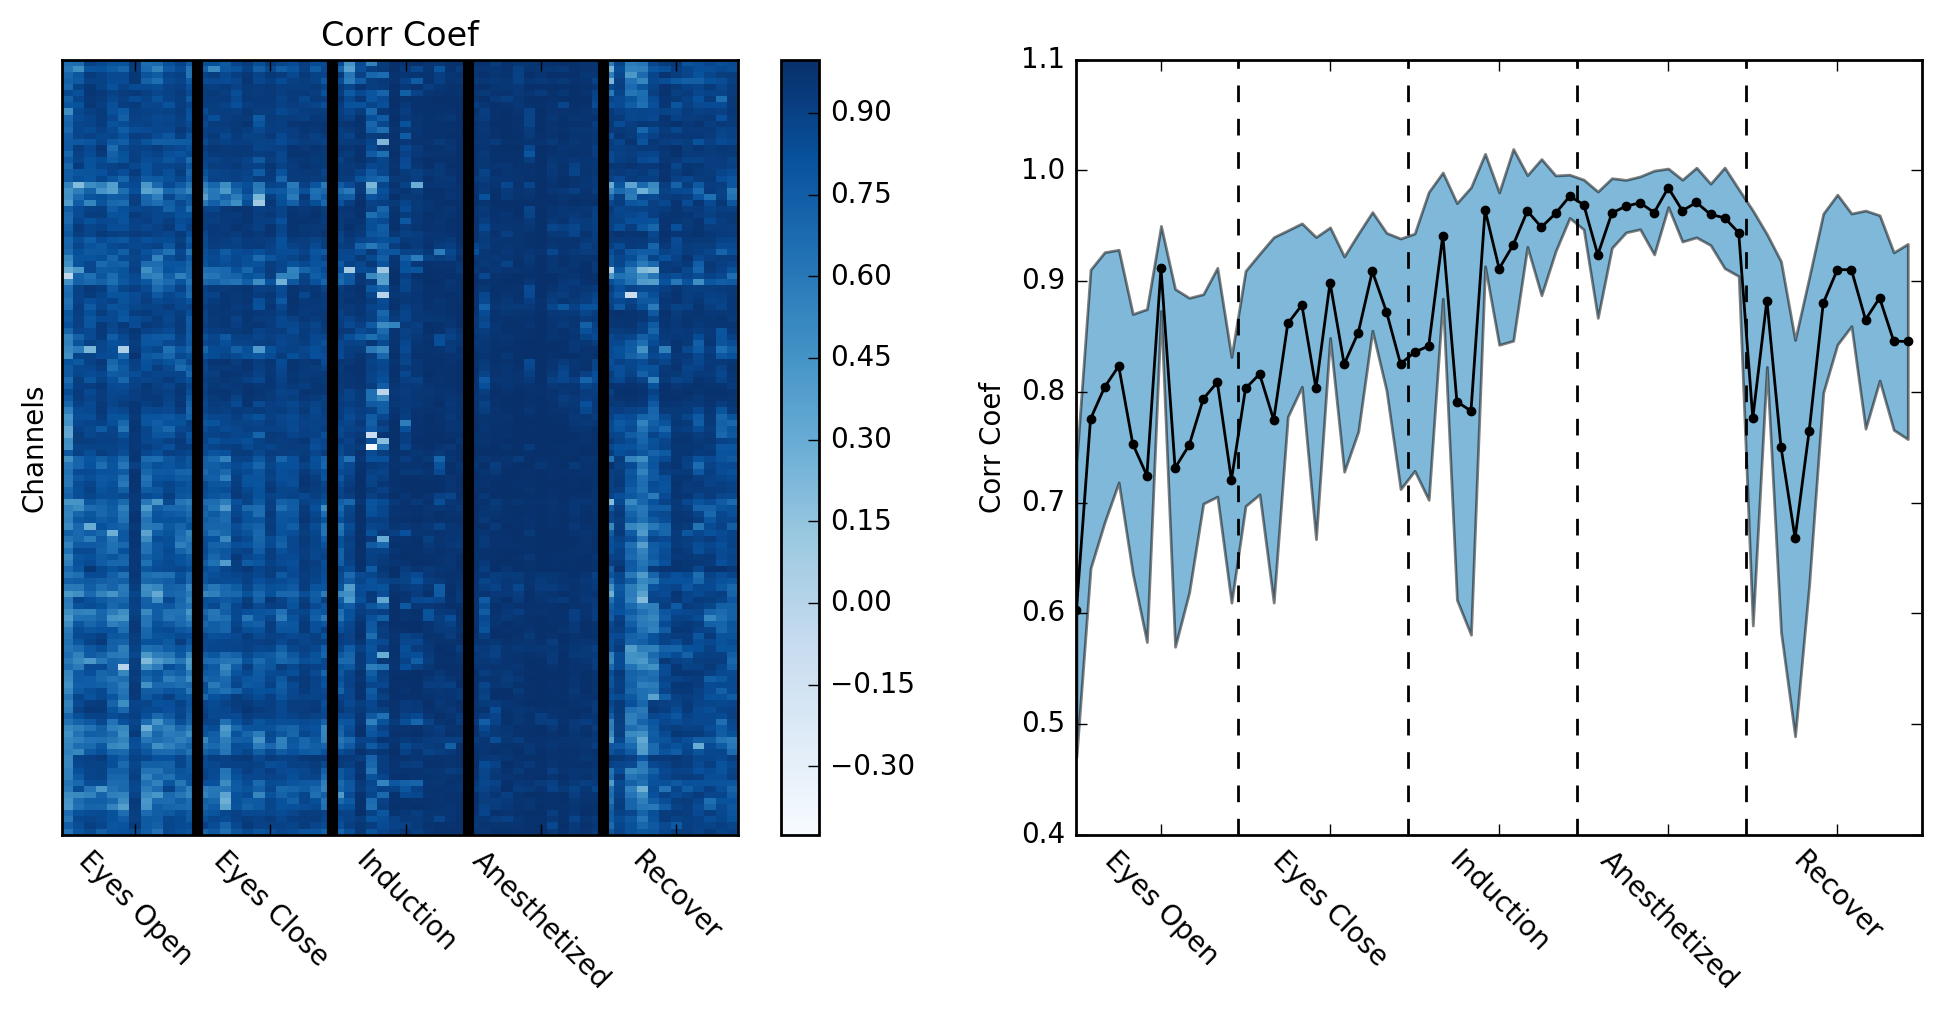

In [41]:
plotting = 'rho'
if plotting is 'rmse':
    plot_data = rmse
    ti = 'RMSE'
elif plotting is 'rho':
    plot_data = rho
    ti = 'Corr Coef'

cond_labels = ['Eyes Open', 'Eyes Close', 'Induction', 'Anesthetized', 'Recover']
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(plot_data, interpolation='none', aspect='auto', origin='lower', cmap='Blues')
plt.colorbar()
XL = plt.xlim()
YL = plt.ylim()
plt.xticks(range(6,60,12),cond_labels, rotation=-45)
plt.yticks([])
plt.ylabel('Channels')
plt.plot([np.arange(12,60,12)-0.5]*2,plt.ylim(), 'k', lw=4)
plt.xlim(XL)
plt.ylim(YL)
plt.title(ti)

plt.subplot(1,2,2)
X_ = np.mean(plot_data,axis=0)
XS_ = np.std(plot_data,axis=0)
plt.fill_between(range(60), X_-XS_, X_+XS_, alpha=0.5)
plt.plot(range(60),X_, 'k.-')
YL = plt.ylim()
plt.plot([np.arange(12,60,12)-0.5]*2,YL, 'k--', lw=1)
plt.ylim(YL)
plt.xticks(range(6,60,12),cond_labels, rotation=-45);
plt.ylabel(ti)

###### plot result on a brain

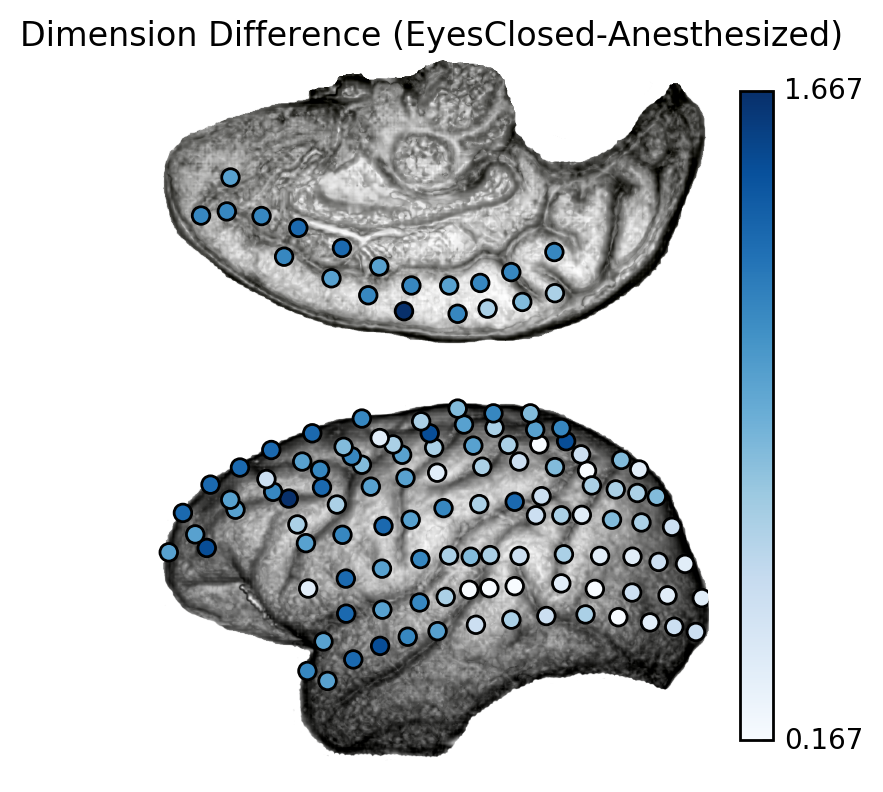

In [534]:
ctx_file = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/GridLocations/20110621KTMD_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_2Dimg/ChibiMap.mat'
plt.figure(figsize=(4,4))
#data = np.array([ch[15] for ch in tau])
data = np.mean(AD[:,1:6],axis=1)-np.mean(AD[:,6:12],axis=1)
data = np.mean(AD[:,6:12],axis=1)-np.mean(AD[:,18:24],axis=1)
ctx_viz(ctx_file, data=data, chans = channels-1, ms=40.)
plt.title('Dimension Difference (EyesClosed-Anesthesized)')
#ctx_viz(ctx_file, ms=40.)

(60, 8, 25, 20)


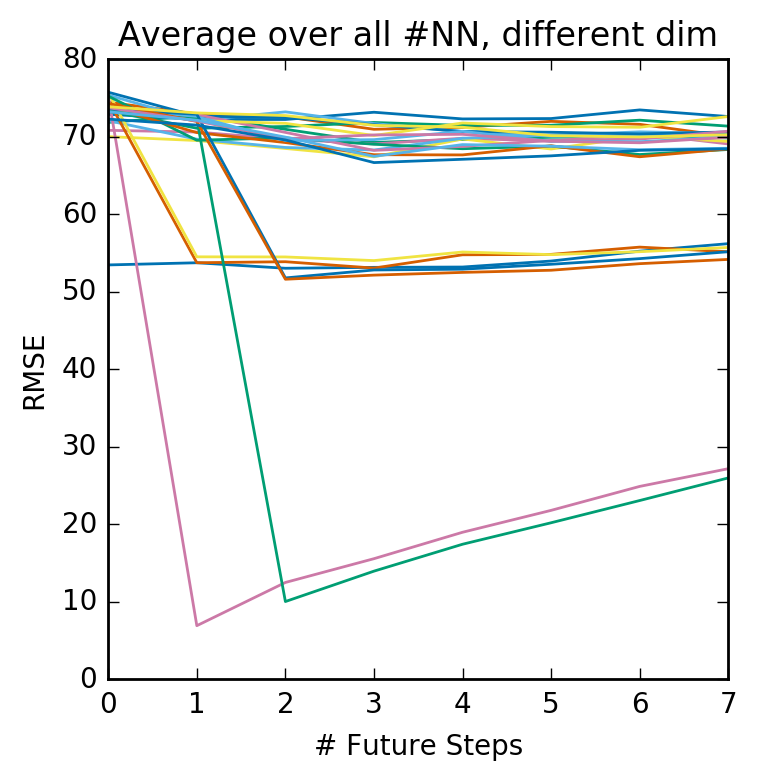

In [15]:
print res_chan['rho'].shape
rho_ = res_chan['rho']
rmse_ = res_chan['rmse']
plot_data = np.mean(rmse_[25,:,:,:],axis=-1)
#plot_data = rmse_[25,5,:,:].T

plt.figure(figsize=(4,4))
plt.plot(plot_data);
plt.xlabel('# Future Steps')
plt.ylabel('RMSE')
plt.title('Average over all #NN, different dim')

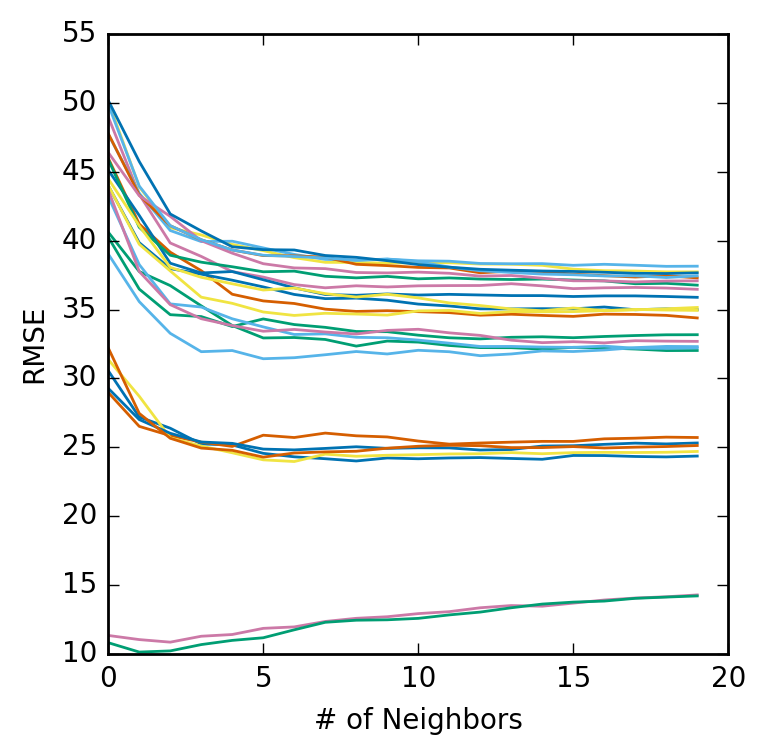

In [17]:
plot_data = rmse_[40,3,:,:].T
plt.figure(figsize=(4,4))
plt.plot(plot_data);
plt.xlabel('# of Neighbors')
plt.ylabel('RMSE')